In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [11]:
def prepare(filepath, size):
    IMG_SIZE = size
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # read in the image, convert to grayscale
    img_array = img_array / 255.0
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize image to match model's expected sizing
    return new_array  # return the image

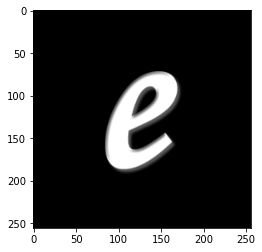

In [35]:
x_train = prepare("e.jpg", 256)
plt.imshow(x_train, cmap=plt.cm.binary)
plt.show()

In [37]:
def mc_sim(x_train, size=64, launch="iso", length=0.25, thres=0.01):
    x, y, z = 0, 0, 0
    ux, uy, uz = 0, 0, 0
    W = 0
    mua = 1.673
    mus = 312
    g = 0.9
    albedo = mus / (mus + mua)
    output = np.zeros((size, size))

    for i in range(size):
        for j in range(size):

            if launch == "col":
                # COLLIMATED LAUNCH
                W = x_train[i][j]
                x = i
                y = j
                z = 0
                uz = 1
            if launch == "iso":
                # ISOTROPIC LAUNCH
                W = x_train[i][j]
                x = i
                y = j
                z = 0

                costheta = 2 * np.random.rand() - 1
                sintheta = np.sqrt(1 - costheta ** 2)
                psi = 2 * np.pi * np.random.rand()
                ux = sintheta * np.cos(psi)
                uy = sintheta * np.sin(psi)
                uz = costheta

            while length > z > -0.1:
                # HOP
                s = -np.log(np.random.rand()) / (mua + mus)
                x += s * ux
                y += s * uy
                z += s * uz

                # DROP
                absorb = W * (1 - albedo)
                W -= absorb
                if W <= thres:
                    break

                # SPIN/SCATTER
                rnd = np.random.rand()
                if g == 0:
                    costheta = 2 * rnd - 1
                else:
                    temp = (1 - g ** 2) / (1 - g + 2 * rnd * g)
                    costheta = (1 + g ** 2 - temp ** 2) / (2 * g)
                sintheta = np.sqrt(1 - costheta ** 2)

                psi = 2 * np.pi * np.random.rand()
                cospsi = np.cos(psi)
                if psi < np.pi:
                    sinpsi = np.sqrt(1 - cospsi ** 2)
                else:
                    sinpsi = -np.sqrt(1 - cospsi ** 2)

                if (1 - abs(uz)) <= 10 ** -12:
                    uxx = sintheta * cospsi
                    uyy = sintheta * sinpsi
                    uzz = costheta * np.sign(uz)
                else:
                    temp = np.sqrt(1 - uz ** 2)
                    uxx = sintheta * (ux * uz * cospsi - uy * sinpsi) / temp + ux * costheta
                    uyy = sintheta * (uy * uz * cospsi + ux * sinpsi) / temp + uy * costheta
                    uzz = -sintheta * cospsi * temp + uz * costheta

                ux = uxx
                uy = uyy
                uz = uzz

            x = int(np.round(x))
            y = int(np.round(y))

            if z >= length:
                if 0 <= x < size:
                    if 0 <= y < size:
                        output[x][y] = W
    return output

In [38]:
output = mc_sim(x_train,length=0.5,size=256) #takes approximately 11 minutes for length 0.5 and size 256

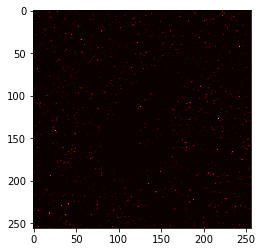

In [40]:
plt.imshow(output, cmap = 'hot')
plt.savefig("e_0.5_256.jpg", bbox_inches='tight', pad_inches=0, dpi =1200)
plt.show()